# Controls Application Analysis

Here we dump metrics from all applications, console, java, etc. and collect them in a single data frame. This allows us to explore the data and discover insights that would be difficult to know otherwise.

## Single Source of Truth

We will keep all data in the `app_data.json` file. So, if you generate data that could be used for future analysis, add it to the `app_data` data frame and then write the data frame back to the `app_data.json` file.

```python
# Example data concatenation
# app_data = pd.concat([app_data, line_data])
app_data.to_json("app_data.json", orient="records", indent=2)
```

### Output to JSON

If you uncomment this, it will output to `test.json`. Use this as a guide to update the `app_data.json` file. Check the changes with a print or the `test.json` file before committing changes to `app_data.json`.

In [1]:
# app_data = pd.read_json('app_data.json')
# app_data = app_data.merge(line_data, on="program")
# app_data.to_json('test.json', orient='records', indent=2)

## Imports

To install these you can run `python3 -m pip install -r requirements.txt`.

In [1]:
import json

import pandas as pd
# Even though we don't use this, it has useful defaults, so let's keep it.
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.optimize import curve_fit

In [3]:
app_data = pd.read_json('app_data.json')
java_data = pd.read_json('java_data.json')

# We will want to filter by whether or not an application is mapped (NaN)
# this only applies for pas

# Filter by exection_count > 0 for pas & sas

# Define logical conditions to cut application from data
# count -> lines of code
# execution count -> number of times application is opened 
nonobsolete_condition = app_data["status"] == "active"
nonzero_lines_condition = app_data["count"]>0
nonzero_execution_count_condition = app_data["execution_count"]>0
mapped_condition = app_data["index_page"].notnull()

# Logical AND all the conditions
cut_condition = nonobsolete_condition*nonzero_lines_condition*nonzero_execution_count_condition*mapped_condition
print(f'{np.where(cut_condition)[0].size} elements made the cut out of {np.asarray(app_data["count"]).size}.')

lines = np.asarray(app_data['count'])[np.where(cut_condition)]

328 elements made the cut out of 1383.


In [4]:
# Apply fit to data
def func(x, a, b, c):
    return a * np.exp(-1.0*(x/b)) + c # Exponential decay

Decay constant is 4048.882260768984


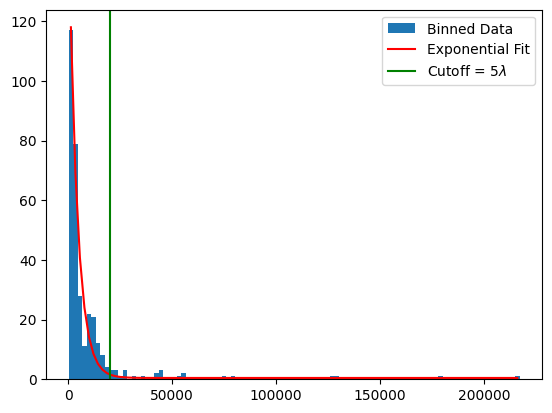

In [5]:
x = np.linspace(0, lines.size - 1, lines.size)
nbins = 100

n, bin_borders, _ = plt.hist(lines, nbins, label="Binned Data")
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
p0 = [1, 1E2, 1]
popt, pcov = curve_fit(func, bin_centers, n, p0)
plt.plot(bin_centers, func(bin_centers, *popt), 'r-', label="Exponential Fit")
#plt.xlim(0,50000)
#plt.gca().set_yscale('log')
cutoff = 5 # units of fit characteristic decay constant
plt.axvline(x = cutoff*popt[1], ymin = 0, ymax = 1, color='green', label = f"Cutoff = {cutoff}"+r"$\lambda$")
plt.legend()

print(f"Decay constant is {popt[1]}")

# Compute total lines of code within the cutoff
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]
# Find index that is nearest to the cutoff, integrate number of lines up to cutoff
# Note from Adam: I don't think this is working yet.
#cutoff_index = np.where(lines == find_nearest(lines, func(x,*popt)))[0][0]
#lines_at_cutoff = np.sum(lines[0:cutoff_index])
#print(f"Total lines of code up to cutoff is {lines_at_cutoff}")

In [6]:
# Some statistics to see what's interesting
mean = np.mean(lines)
median = np.median(lines)
mode = stats.mode(lines)[0]
sum = np.sum(lines)
max = np.max(lines)
print(f"Mean: {mean:.0f}, Median: {median:.0f}, Mode: {mode:.0f}, Sum: {sum:.0f}, Max: {max}")

Mean: 9119, Median: 3654, Mode: 354, Sum: 2990978, Max: 216997


In [7]:
# Determine PA# nearest to median
median_index = np.where(lines == find_nearest(lines, np.median(lines)))[0][0]
app_data["program"][median_index]

'pa0048'

#### Ideas:
- Remove unused applications from dataset, if possible (i.e. not mapped to index page, not frequently used over time frame, Linac)
- Weight applications by priority (usage stats and interview criticality), redo analysis to determine window
- Use exponential fit, choose windows as integer multiples fit characteristic time constant (instead of standard deviation)

Maybe for CD-1, do first and third idea above. Priority weighting can refine estimate for CD-2.

John: effort is not linear with lines-of-code. Really wants to see how long it takes to port median application.

## Estimation Calculations

Functions below include assumptions and equations for quickly calculating estimates based on lines of code (loc).


In [29]:
parameter_page_loc = app_data[app_data["program"] == "pa0052"]["count"] # pa0052 is the parameter page id
# The parameter page took .25 FTEs to reach minimal viable product (MVP)
ftes_to_mvp = .25
# Each 204.05 WBS has 5 FTEs available
available_ftes = 5
# An FTE is 52 weeks
fte_weeks = 52
# While our iterations are 4 weeks, we only get 3 weeks of work to allow a week for catch-up and education
iteration_weeks = 4
iteration_work_weeks = 3
# Available FTEs per week
ftes_per_week = available_ftes/fte_weeks
# We have 3 weeks of work per iteration
work_per_iteration = ftes_per_week*iteration_work_weeks

def loc_to_ftes(loc):
    return loc*ftes_to_mvp/parameter_page_loc

def ftes_to_iterations(ftes):
    return ftes/work_per_iteration

def loc_to_iterations(loc):
    return ftes_to_iterations(loc_to_ftes(loc))


In [31]:
app_data['iterations'] = app_data['count'].apply(loc_to_iterations)

## Dependencies

`get_dependencies.py` generates `dependencies.json`.

`dependencies.json` has the reported dependencies of each property by reading the the associated `depends.opt` in the project directory in mecca.

In [4]:
# Load the JSON data
with open('dependencies.json', 'r') as fp:
   data = json.load(fp)

# Preprocess the JSON data
preprocessed_data = []
for project, deps in data.items():
   for dep in deps:
       preprocessed_data.append({'project': project, 'dependency': dep})

# Load the preprocessed data into a DataFrame
dependencies = pd.DataFrame(preprocessed_data)
grouped_dependencies = dependencies.groupby('project')
no_dependencies = grouped_dependencies.filter(lambda x: len(x) == 0)
counts = dependencies['dependency'].value_counts()

In [39]:
# Recursively track dependencies to see if there are circular dependencies
def find_cycle(project, visited, stack, path, dependencies):
    # Mark the current node as visited and add it to the stack
    visited.add(project)
    stack.add(project)
    path.append(project)

    # Recur for all dependencies of this project
    for dep in dependencies[dependencies['project'] == project]['dependency']:
        # print(dep)
        # If the dependency is a project, and is not visited, then recur on it
        # if dep in dependencies['project'] and dep not in visited:
        if dependencies['project'].str.contains(dep).any() and dep not in visited:
            cycle = find_cycle(dep, visited, stack, path, dependencies)
            if cycle:
                return cycle
        # If the dependency is in the stack, then it has a cycle
        elif dep in stack:
            # Get the index of the dependency in the path
            index = path.index(dep)
            # Return the cycle from the path
            return path[index:]

    # Remove the project from the stack as it finishes
    stack.remove(project)
    path.pop()

    return None

def find_interdependencies(dependencies):
    # Create a set to store visited projects and a stack
    visited = set()
    stack = set()
    path = []

    # Call the recursive function to detect cycle in different DFS trees
    for project in dependencies['project']:
        if project not in visited:
            cycle = find_cycle(project, visited, stack, path, dependencies)
            if cycle:
                return cycle

    return None

In [40]:
find_interdependencies(dependencies)

['ul_clib', 'ul_acl']

In [44]:
# Recursively find all dependencies of a project
def find_dependencies(project, visited, dependencies):
    # Mark the current node as visited and add it to the stack
    visited.add(project)

    # Recur for all dependencies of this project
    for dep in dependencies[dependencies['project'] == project]['dependency']:
        # If the dependency is a project, and is not visited, then recur on it
        if dependencies['project'].str.contains(dep).any() and dep not in visited:
            find_dependencies(dep, visited, dependencies)

In [45]:
found_dependencies = set()
find_dependencies('acld', found_dependencies, dependencies)
print(found_dependencies)

{'ul_cbsaux', 'ul_clib', 'ul_feconf_protocol', 'ul_model', 'ul_history', 'ul_dialoglib', 'ul_lextools', 'ul_windowlib', 'ul_dbnews_protocol', 'ul_product_setup', 'ul_calc_device', 'ul_physlib', 'ul_vxi11', 'ul_oac', 'ul_pbar_general', 'ul_cnscom', 'boost', 'acld', 'ul_scopes', 'ul_mcsets_protocol', 'ul_dabbel', 'ul_cxxacnet', 'ul_crg', 'ul_acnetd', 'ul_acld_protocol', 'ul_sql', 'ul_dpm_protocol', 'ul_pbar_gpib', 'ul_acl', 'ul_pbar_instruments', 'ul_threaded', 'ul_pasa', 'ul_mirg', 'ul_multiwire', 'ul_pb_swtree'}
